In [8]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [9]:
conda install -c conda-forge prophet


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import KMeans
from prophet import Prophet

In [13]:
dataset=pd.read_csv("covid_19_clean_complete.csv")

In [14]:
dataset.shape

(16066, 8)

In [15]:
dataset.describe

<bound method NDFrame.describe of       Province/State  Country/Region      Lat      Long     Date  Confirmed  \
0                NaN        Thailand  15.0000  101.0000  1/22/20          2   
1                NaN           Japan  36.0000  138.0000  1/22/20          2   
2                NaN       Singapore   1.2833  103.8333  1/22/20          0   
3                NaN           Nepal  28.1667   84.2500  1/22/20          0   
4                NaN        Malaysia   2.5000  112.5000  1/22/20          0   
...              ...             ...      ...       ...      ...        ...   
16061        Bermuda  United Kingdom  32.3078  -64.7505  3/19/20          2   
16062            NaN            Chad  15.4542   18.7322  3/19/20          1   
16063            NaN     El Salvador  13.7942  -88.8965  3/19/20          1   
16064            NaN            Fiji -17.7134  178.0650  3/19/20          1   
16065            NaN       Nicaragua  12.8654  -85.2072  3/19/20          1   

       Deaths  Re

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16066 entries, 0 to 16065
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  7598 non-null   object 
 1   Country/Region  16066 non-null  object 
 2   Lat             16066 non-null  float64
 3   Long            16066 non-null  float64
 4   Date            16066 non-null  object 
 5   Confirmed       16066 non-null  int64  
 6   Deaths          16066 non-null  int64  
 7   Recovered       16066 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1004.3+ KB


In [17]:
daily = dataset.sort_values(['Date','Country/Region','Province/State'])
latest = dataset[dataset.Date == daily.Date.max()]
latest.head()

Province/State Country/Region      Lat      Long    Date  Confirmed  \
13019            NaN       Thailand  15.0000  101.0000  3/9/20         50   
13020            NaN          Japan  36.0000  138.0000  3/9/20        511   
13021            NaN      Singapore   1.2833  103.8333  3/9/20        150   
13022            NaN          Nepal  28.1667   84.2500  3/9/20          1   
13023            NaN       Malaysia   2.5000  112.5000  3/9/20        117   

       Deaths  Recovered  
13019       1         31  
13020      10         76  
13021       0         78  
13022       0          1  
13023       0         24

In [18]:
data=latest.rename(columns={ "Country/Region": "country", "Province/State": "state","Confirmed":"confirm","Deaths": "death","Recovered":"recover"})
data.head()

state    country      Lat      Long    Date  confirm  death  recover
13019   NaN   Thailand  15.0000  101.0000  3/9/20       50      1       31
13020   NaN      Japan  36.0000  138.0000  3/9/20      511     10       76
13021   NaN  Singapore   1.2833  103.8333  3/9/20      150      0       78
13022   NaN      Nepal  28.1667   84.2500  3/9/20        1      0        1
13023   NaN   Malaysia   2.5000  112.5000  3/9/20      117      0       24

In [19]:
dgc=data.groupby("country")[['confirm', 'death', 'recover']].sum().reset_index()

dgc.head()

country  confirm  death  recover
0          Afghanistan        4      0        0
1              Albania        2      0        0
2              Algeria       20      0        0
3              Andorra        1      0        0
4  Antigua and Barbuda        0      0        0

In [20]:
import folium
worldmap = folium.Map(location=[32.4279,53.6880 ], zoom_start=4,tiles='Stamen Toner')

for Lat, Long, state in zip(data['Lat'], data['Long'],data['state']):
    folium.CircleMarker([Lat, Long],
                        radius=5,
                        color='red',
                      popup =('State: ' + str(state) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(worldmap)
worldmap

In [21]:
fig = px.bar(dgc[['country', 'confirm']].sort_values('confirm', ascending=False),
             y="confirm", x="country", color='country',
             log_y=True, template='ggplot2', title='Confirmed Cases')
fig.show()

In [22]:
fig = px.bar(dgc[['country', 'recover']].sort_values('recover', ascending=False),
             y="recover", x="country", color='country',
             log_y=True, template='ggplot2', title='Recovered Cases')
fig.show()

In [23]:
fig = px.bar(dgc[['country', 'death']].sort_values('death', ascending=False),
             y="death", x="country", color='country',
             log_y=True, template='ggplot2', title='Death')
fig.show()

In [24]:
bd_data = dataset[dataset['Country/Region']=='Bangladesh']
bdata = bd_data.tail(22)
bdata.head(50)

Province/State Country/Region     Lat     Long     Date  Confirmed  \
10062            NaN     Bangladesh  23.685  90.3563  2/27/20          0   
10339            NaN     Bangladesh  23.685  90.3563  2/28/20          0   
10616            NaN     Bangladesh  23.685  90.3563  2/29/20          0   
10893            NaN     Bangladesh  23.685  90.3563   3/1/20          0   
11170            NaN     Bangladesh  23.685  90.3563   3/2/20          0   
11447            NaN     Bangladesh  23.685  90.3563   3/3/20          0   
11724            NaN     Bangladesh  23.685  90.3563   3/4/20          0   
12001            NaN     Bangladesh  23.685  90.3563   3/5/20          0   
12278            NaN     Bangladesh  23.685  90.3563   3/6/20          0   
12555            NaN     Bangladesh  23.685  90.3563   3/7/20          0   
12832            NaN     Bangladesh  23.685  90.3563   3/8/20          3   
13109            NaN     Bangladesh  23.685  90.3563   3/9/20          3   
13386            NaN     Bangladesh  23.685  90.3563  3/10/20          3   
13663            NaN     Bangladesh  23.685  90.3563  3/11/20          3   
13940            NaN     Bangladesh  23.685  90.3563  3/12/20          3   
14217            NaN     Bangladesh  23.685  90.3563  3/13/20          3   
14494            NaN     Bangladesh  23.685  90.3563  3/14/20          3   
14771            NaN     Bangladesh  23.685  90.3563  3/15/20          5   
15048            NaN     Bangladesh  23.685  90.3563  3/16/20          8   
15325            NaN     Bangladesh  23.685  90.3563  3/17/20         10   
15602            NaN     Bangladesh  23.685  90.3563  3/18/20         14   
15879            NaN     Bangladesh  23.685  90.3563  3/19/20         17   

       Deaths  Recovered  
10062       0          0  
10339       0          0  
10616       0          0  
10893       0          0  
11170       0          0  
11447       0          0  
11724       0          0  
12001       0          0  
12278       0          0  
12555       0          0  
12832       0          0  
13109       0          0  
13386       0          0  
13663       0          0  
13940       0          0  
14217       0          0  
14494       0          0  
14771       0          0  
15048       0          2  
15325       0          3  
15602       1          3  
15879       1          3

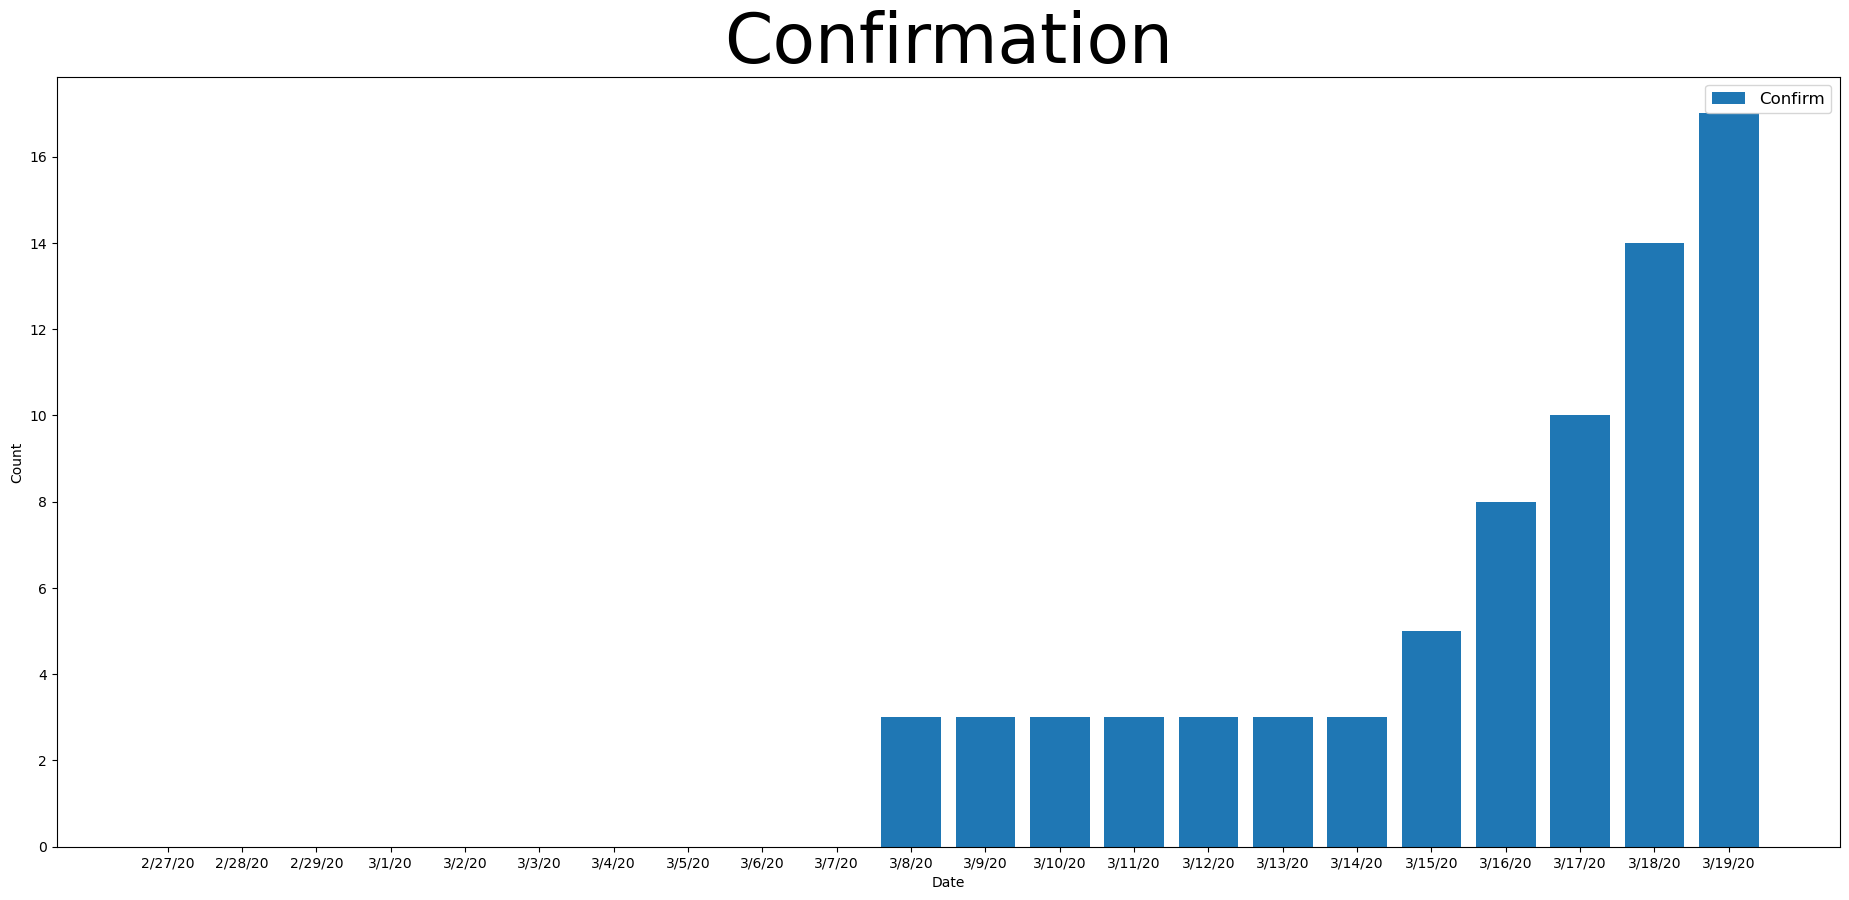

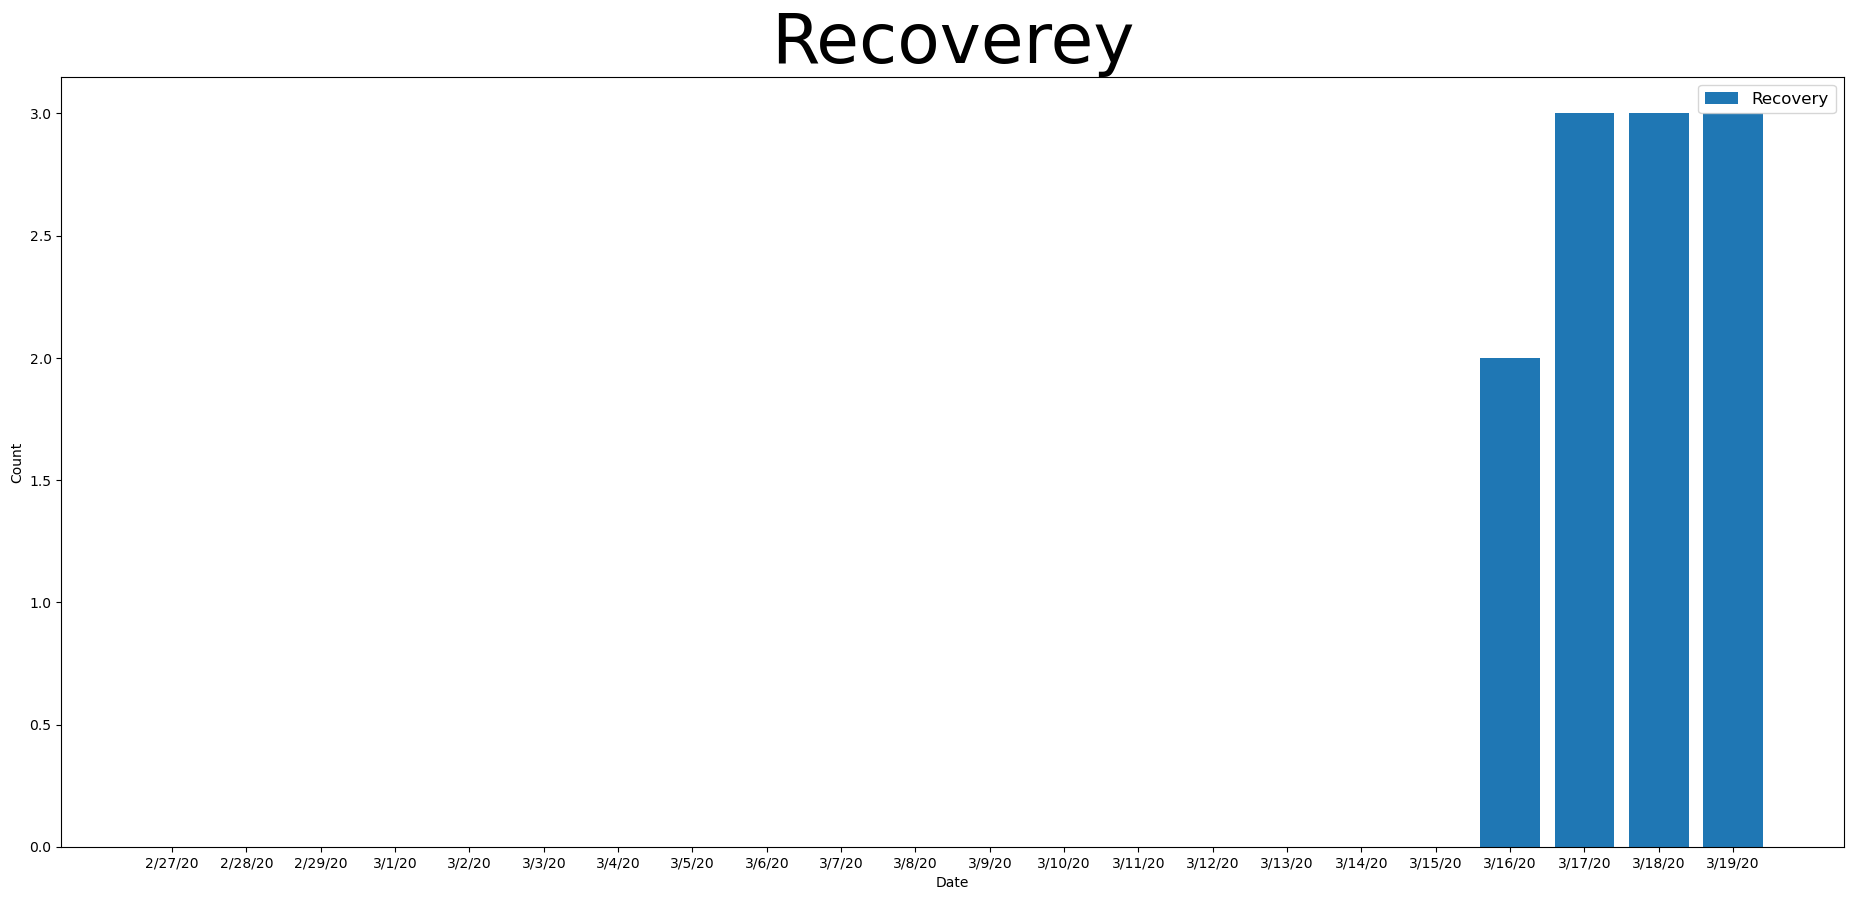

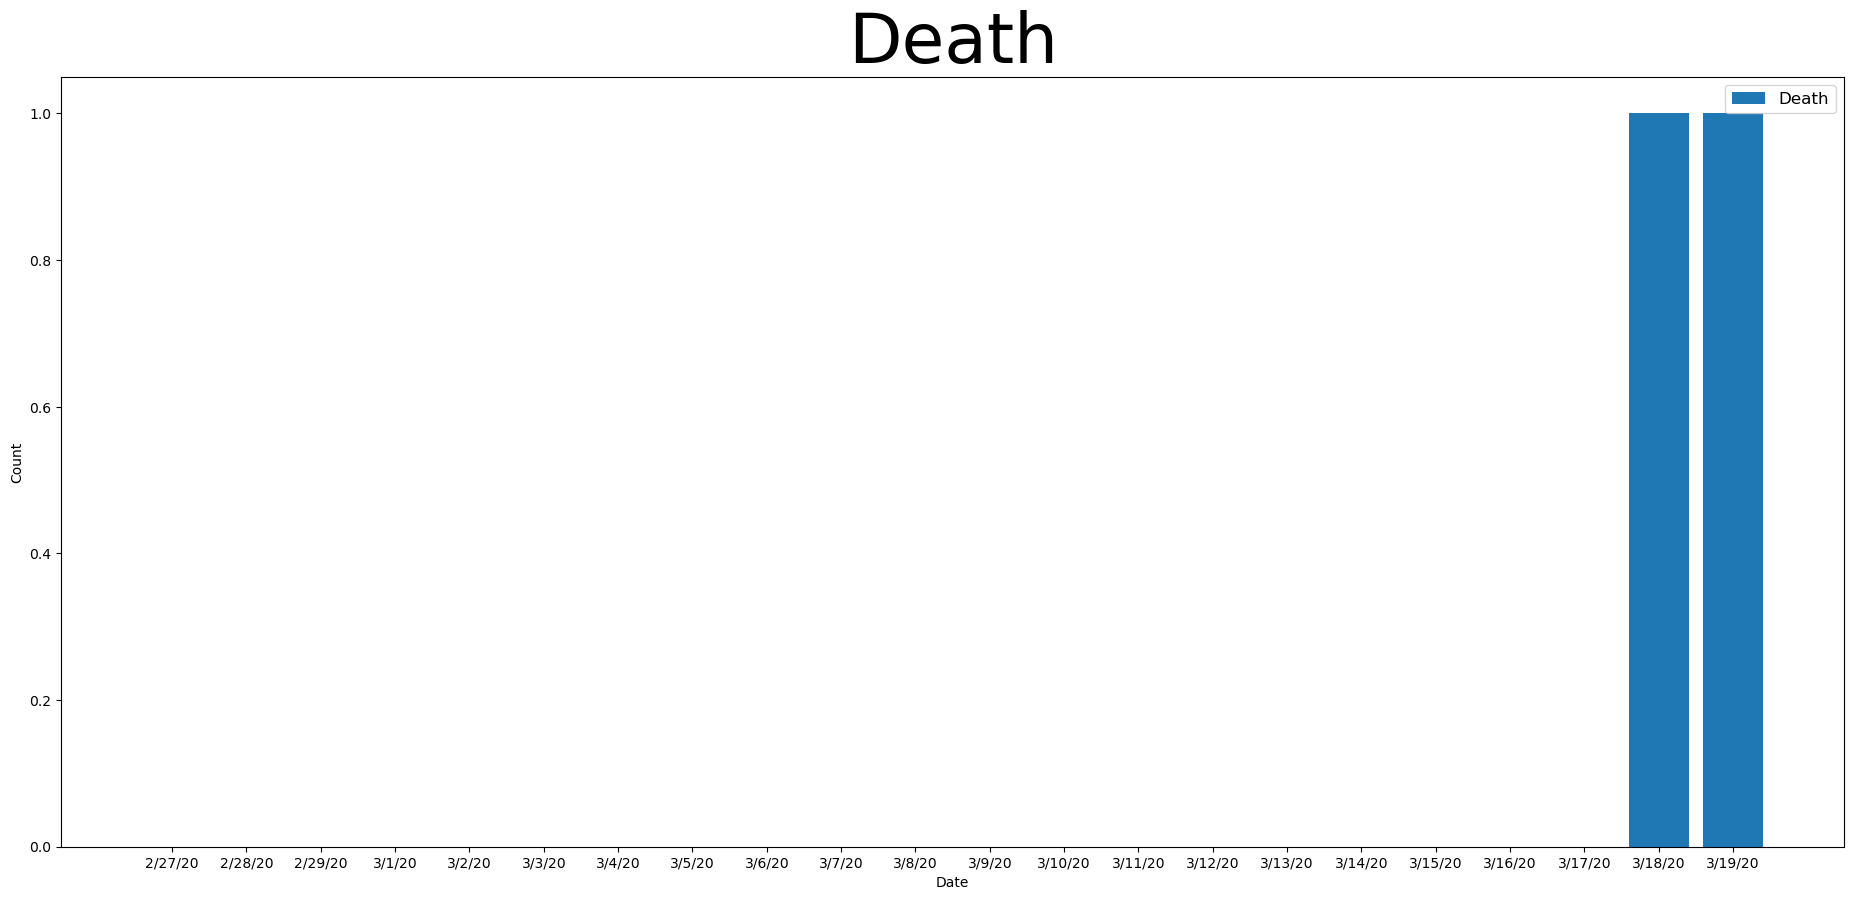

In [25]:
plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Confirmed,label="Confirm")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title("Confirmation",fontsize=50)
plt.show()

plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Recovered,label="Recovery")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title("Recoverey",fontsize=50)
plt.show()


plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Deaths,label="Death")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title("Death",fontsize=50)
plt.show()

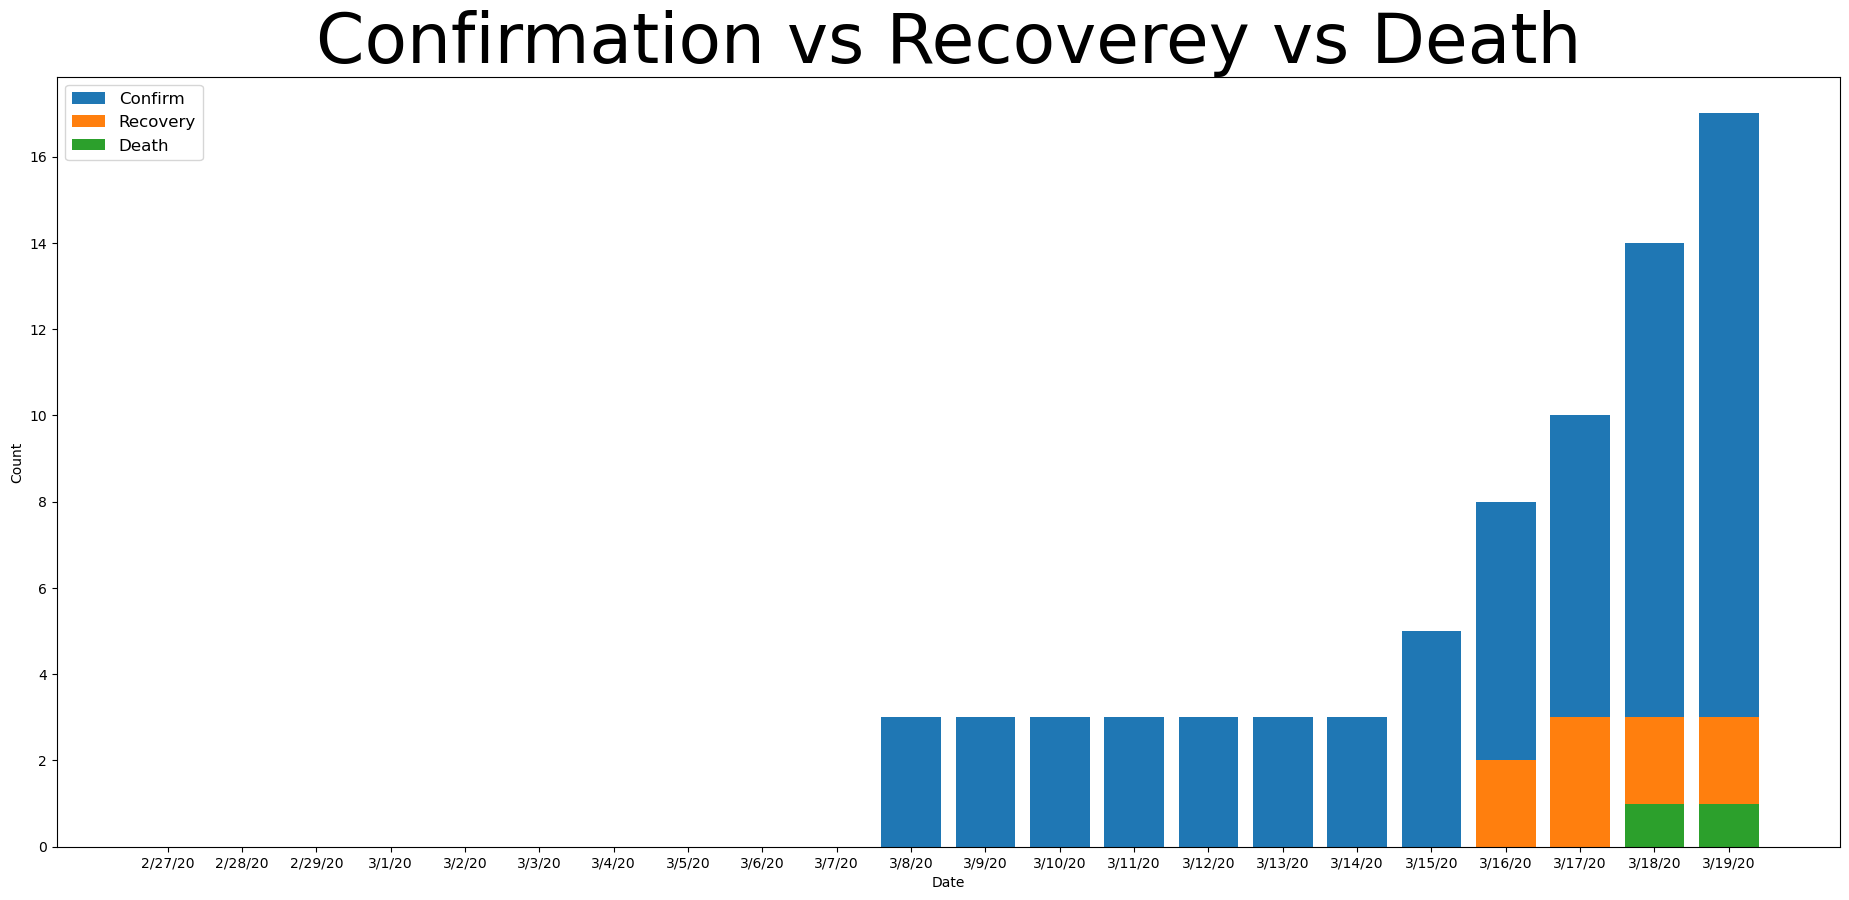

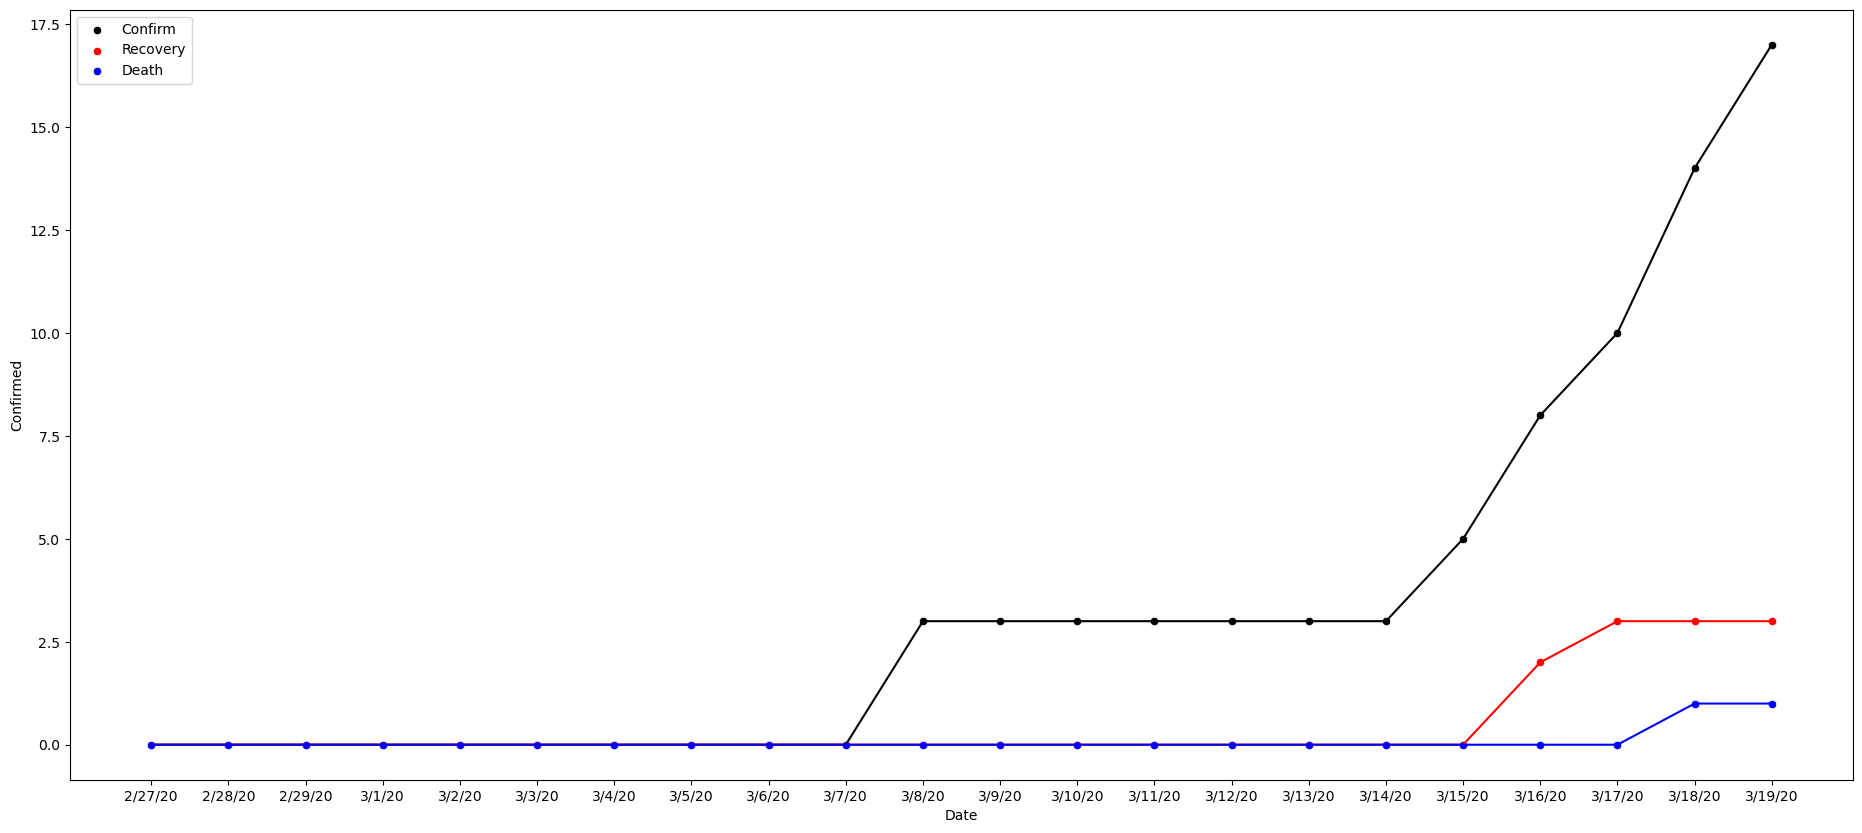

In [26]:
plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Confirmed,label="Confirm")
plt.bar(bdata.Date, bdata.Recovered,label="Recovery")
plt.bar(bdata.Date, bdata.Deaths,label="Death")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title("Confirmation vs Recoverey vs Death",fontsize=50)
plt.show()

f, ax = plt.subplots(figsize=(23,10))
ax=sns.scatterplot(x="Date", y="Confirmed", data=bdata,
             color="black",label = "Confirm")
ax=sns.scatterplot(x="Date", y="Recovered", data=bdata,
             color="red",label = "Recovery")
ax=sns.scatterplot(x="Date", y="Deaths", data=bdata,
             color="blue",label = "Death")
plt.plot(bdata.Date,bdata.Confirmed,zorder=1,color="black")
plt.plot(bdata.Date,bdata.Recovered,zorder=1,color="red")
plt.plot(bdata.Date,bdata.Deaths,zorder=1,color="blue")

In [27]:
bdata['Confirmed_new'] = bdata['Confirmed'] - bdata['Confirmed'].shift(1)
bdata['Recovered_new'] = bdata['Recovered'] - bdata['Recovered'].shift(1)
bdata['Deaths_new'] = bdata['Deaths'] - bdata['Deaths'].shift(1)

/var/folders/5f/qpt2yyxs73g55s4dm6ppxfl00000gn/T/ipykernel_63516/936869123.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5f/qpt2yyxs73g55s4dm6ppxfl00000gn/T/ipykernel_63516/936869123.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5f/qpt2yyxs73g55s4dm6ppxfl00000gn/T/ipykernel_63516/936869123.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [28]:
print(bdata)

      Province/State Country/Region     Lat     Long     Date  Confirmed  \
10062            NaN     Bangladesh  23.685  90.3563  2/27/20          0   
10339            NaN     Bangladesh  23.685  90.3563  2/28/20          0   
10616            NaN     Bangladesh  23.685  90.3563  2/29/20          0   
10893            NaN     Bangladesh  23.685  90.3563   3/1/20          0   
11170            NaN     Bangladesh  23.685  90.3563   3/2/20          0   
11447            NaN     Bangladesh  23.685  90.3563   3/3/20          0   
11724            NaN     Bangladesh  23.685  90.3563   3/4/20          0   
12001            NaN     Bangladesh  23.685  90.3563   3/5/20          0   
12278            NaN     Bangladesh  23.685  90.3563   3/6/20          0   
12555            NaN     Bangladesh  23.685  90.3563   3/7/20          0   
12832            NaN     Bangladesh  23.685  90.3563   3/8/20          3   
13109            NaN     Bangladesh  23.685  90.3563   3/9/20          3   
13386       

In [29]:
bdata = bdata.fillna(0)

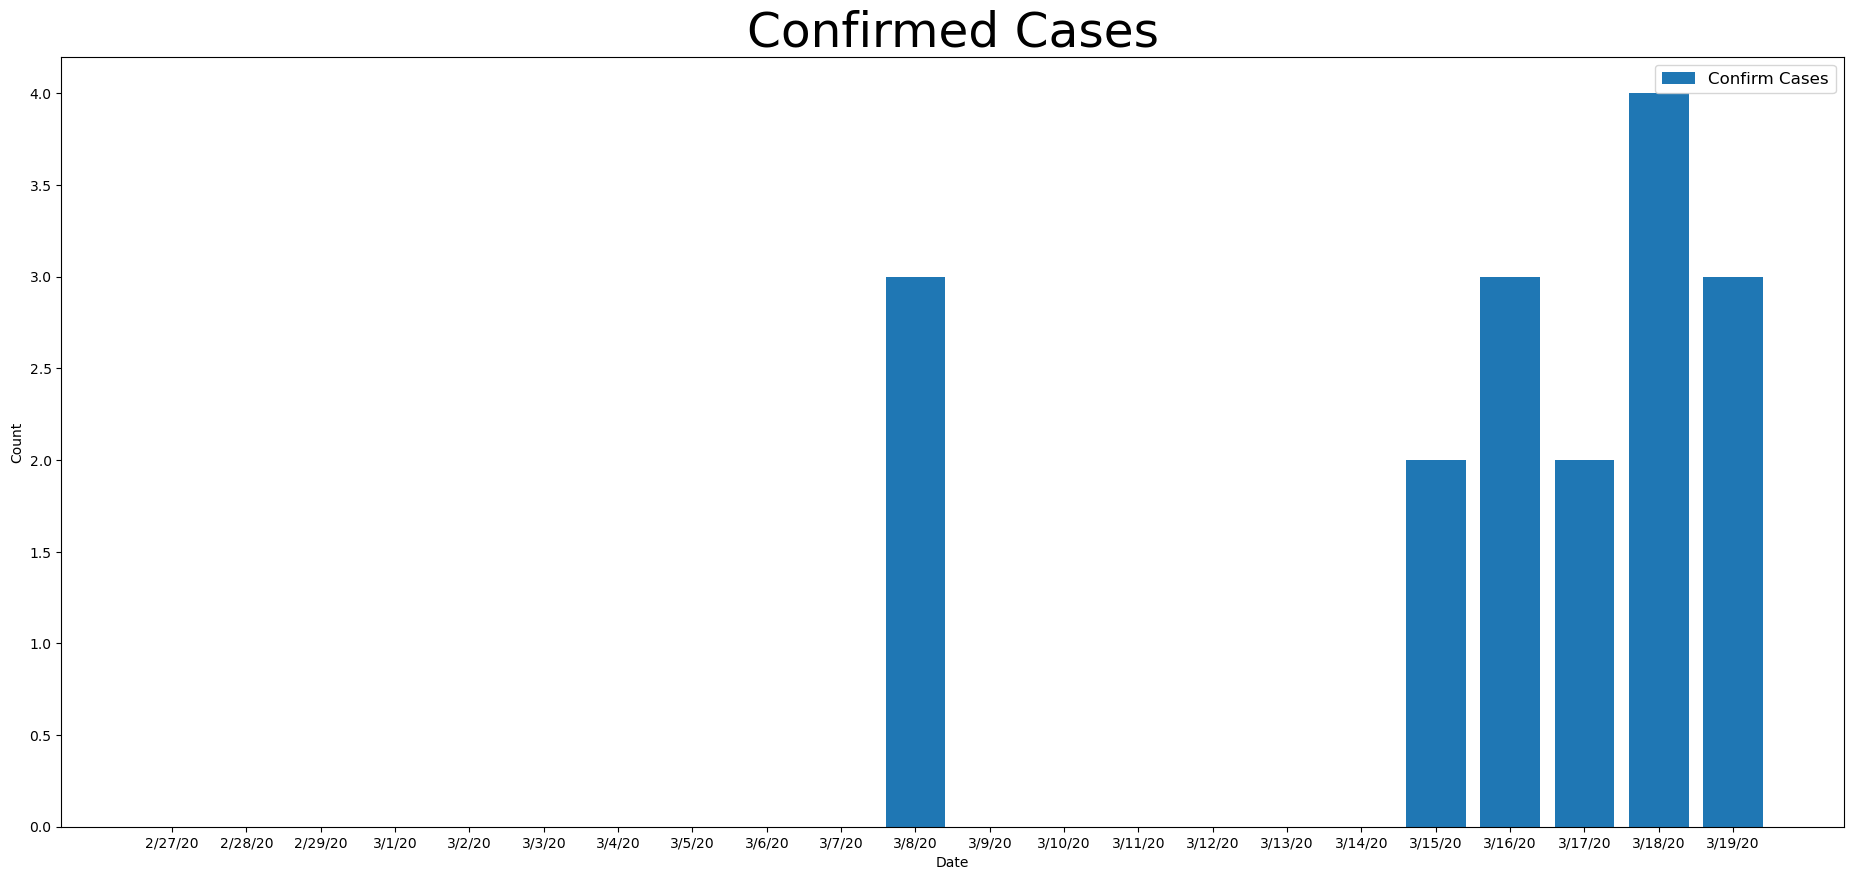

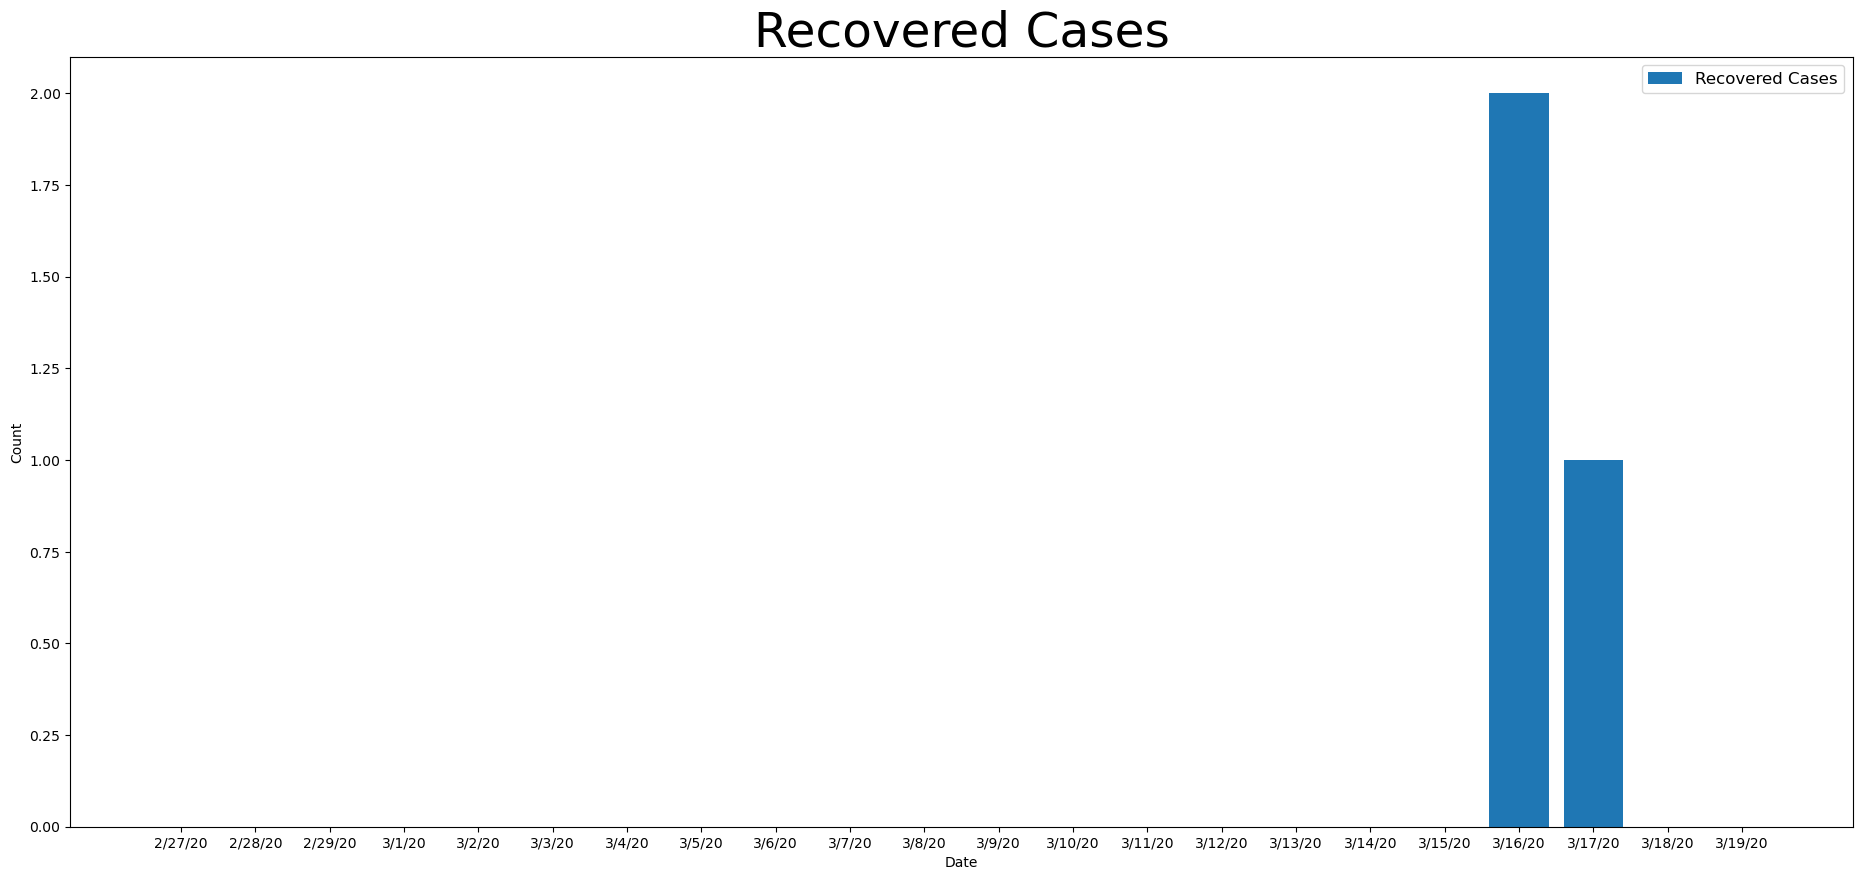

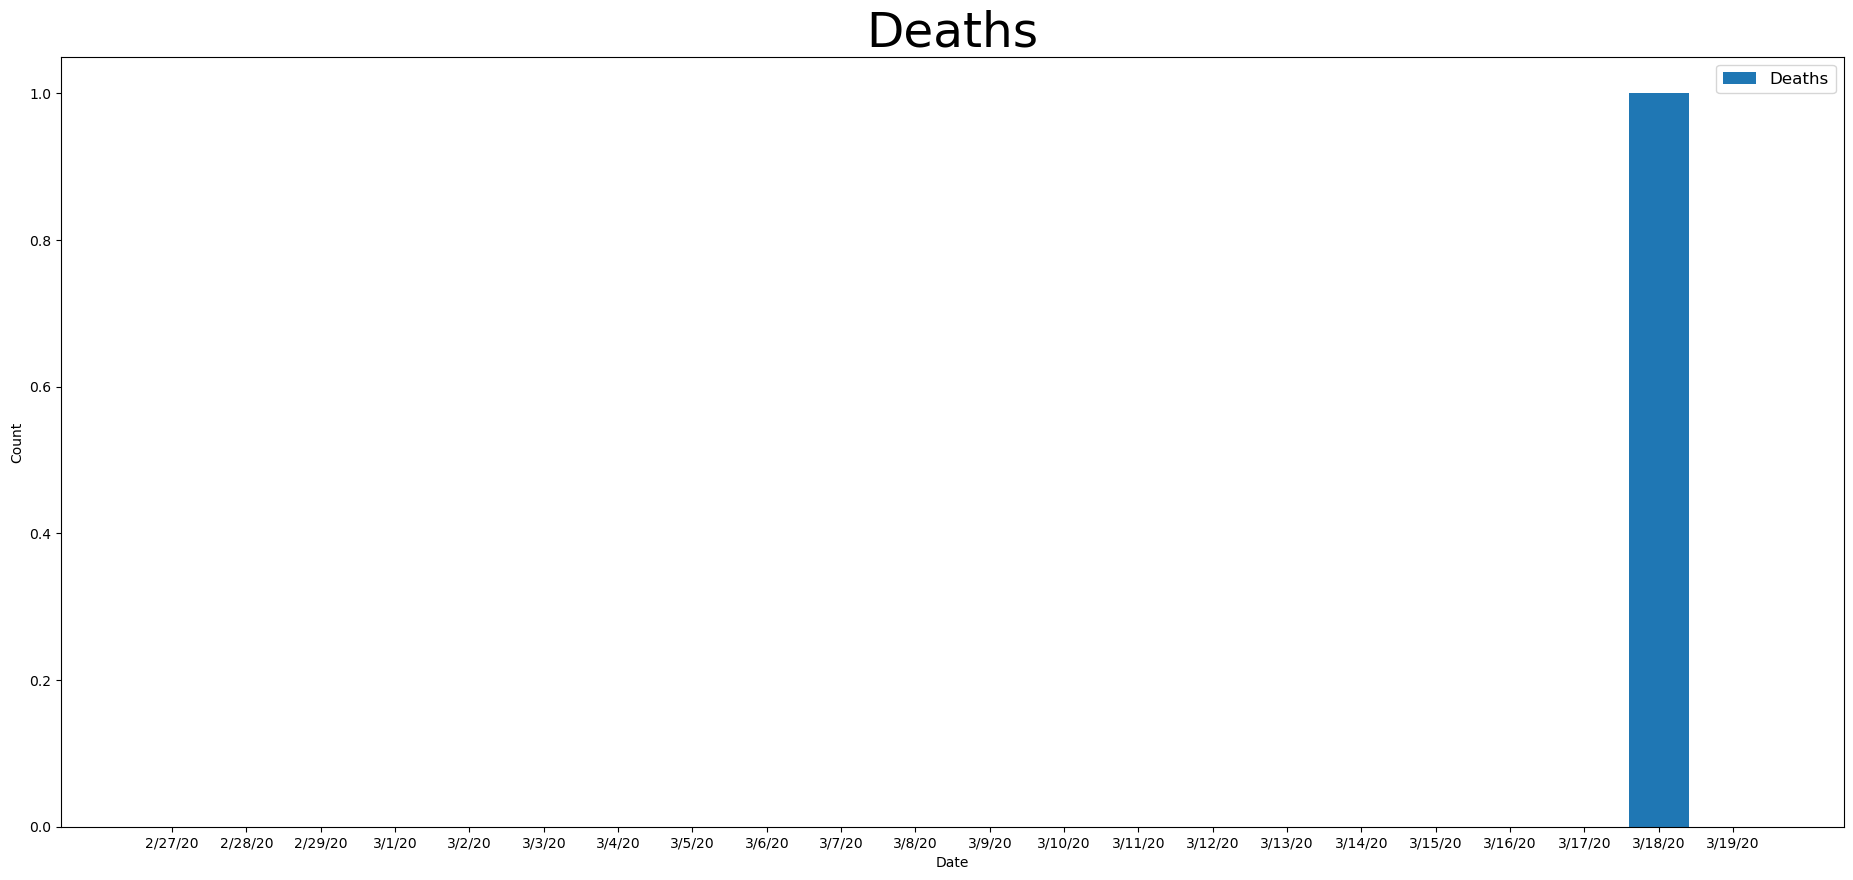

In [30]:
plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Confirmed_new,label="Confirm Cases")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title('Confirmed Cases',fontsize = 35)
plt.show()


plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Recovered_new,label="Recovered Cases")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title('Recovered Cases',fontsize = 35)
plt.show()

plt.figure(figsize=(23,10))
plt.bar(bdata.Date, bdata.Deaths_new,label="Deaths")
plt.xlabel('Date')
plt.ylabel("Count")
plt.legend(frameon=True, fontsize=12)
plt.title('Deaths',fontsize = 35)
plt.show()

In [31]:
bdata.head()

Province/State Country/Region     Lat     Long     Date  Confirmed  \
10062               0     Bangladesh  23.685  90.3563  2/27/20          0   
10339               0     Bangladesh  23.685  90.3563  2/28/20          0   
10616               0     Bangladesh  23.685  90.3563  2/29/20          0   
10893               0     Bangladesh  23.685  90.3563   3/1/20          0   
11170               0     Bangladesh  23.685  90.3563   3/2/20          0   

       Deaths  Recovered  Confirmed_new  Recovered_new  Deaths_new  
10062       0          0            0.0            0.0         0.0  
10339       0          0            0.0            0.0         0.0  
10616       0          0            0.0            0.0         0.0  
10893       0          0            0.0            0.0         0.0  
11170       0          0            0.0            0.0         0.0

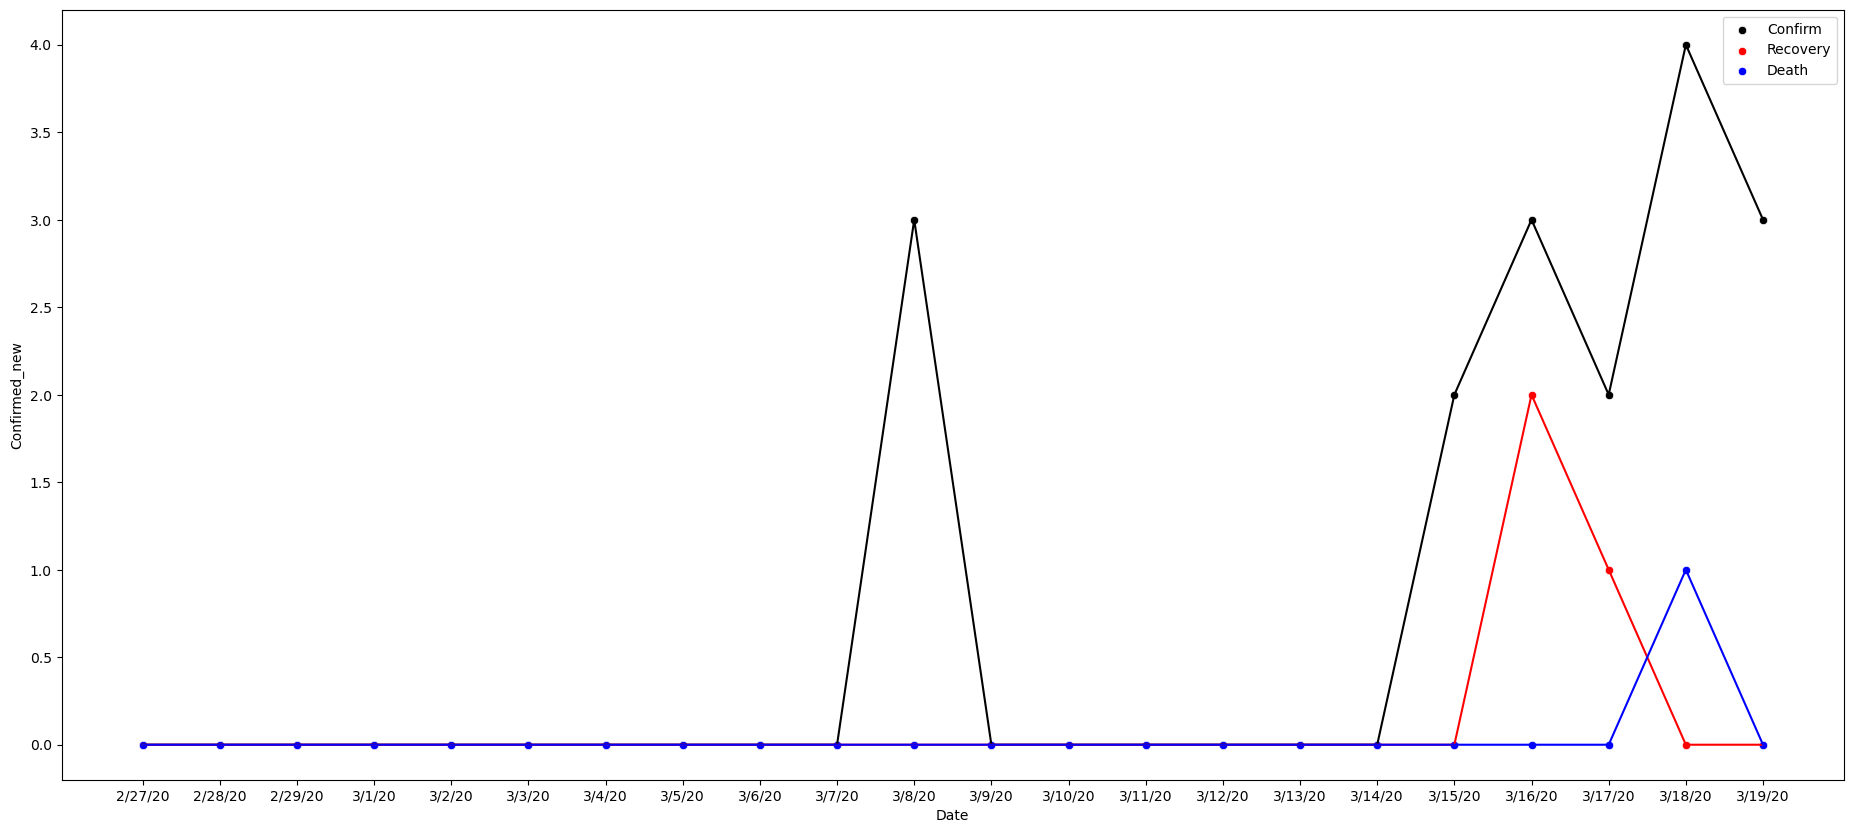

In [32]:
f, ax = plt.subplots(figsize=(23,10))
ax=sns.scatterplot(x="Date", y="Confirmed_new", data=bdata,
             color="black",label = "Confirm")
ax=sns.scatterplot(x="Date", y="Recovered_new", data=bdata,
             color="red",label = "Recovery")
ax=sns.scatterplot(x="Date", y="Deaths_new", data=bdata,
             color="blue",label = "Death")
plt.plot(bdata.Date,bdata.Confirmed_new,zorder=1,color="black")
plt.plot(bdata.Date,bdata.Recovered_new,zorder=1,color="red")
plt.plot(bdata.Date,bdata.Deaths_new,zorder=1,color="blue")

In [33]:
dgd=data.groupby("Date")[['confirm', 'death', 'recover']].sum().reset_index()

dgd.head()

Date  confirm  death  recover
0  3/9/20   113044   3966    62487

In [34]:
r_cm = float(dgd.recover/dgd.confirm)
d_cm = float(dgd.death/dgd.confirm)

/var/folders/5f/qpt2yyxs73g55s4dm6ppxfl00000gn/T/ipykernel_63516/1511693009.py:1: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/var/folders/5f/qpt2yyxs73g55s4dm6ppxfl00000gn/T/ipykernel_63516/1511693009.py:2: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



In [35]:
print("The percentage of recovery after confirmation is "+ str(r_cm*100) )
print("The percentage of death after confirmation is "+ str(d_cm*100) )

The percentage of recovery after confirmation is 55.27670641520116
The percentage of death after confirmation is 3.508368422914971


In [36]:
global_data = pd.read_csv("covid_19_data.csv")

In [37]:
# This functions smooths data, thanks to Dan Pearson. We will use it to smooth the data for growth factor.
def smoother(inputdata,w,imax):
    data = 1.0*inputdata
    data = data.replace(np.nan,1)
    data = data.replace(np.inf,1)
    #print(data)
    smoothed = 1.0*data
    normalization = 1
    for i in range(-imax,imax+1):
        if i==0:
            continue
        smoothed += (w**abs(i))*data.shift(i,axis=0)
        normalization += w**abs(i)
    smoothed /= normalization
    return smoothed

def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed-confirmed_iminus1)/(confirmed_iminus1-confirmed_iminus2)

def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return (confirmed/confirmed_iminus1)

# This is a function which plots (for in input country) the active, confirmed, and recovered cases, deaths, and the growth factor.
def plot_country_active_confirmed_recovered(country):

    # Plots Active, Confirmed, and Recovered Cases. Also plots deaths.
    country_data = global_data[global_data['Country/Region']==country]
    table = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
    table['ActiveCases'] = table['Confirmed'] - table['Recovered'] - table['Deaths']
    table2 = pd.pivot_table(table, values=['ActiveCases','Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
    table3 = table2.drop(['Deaths'], axis=1)

    # Growth Factor
    w = 0.5
    table2['GrowthFactor'] = growth_factor(table2['Confirmed'])
    table2['GrowthFactor'] = smoother(table2['GrowthFactor'],w,5)

    # 2nd Derivative
    table2['2nd_Derivative'] = np.gradient(np.gradient(table2['Confirmed'])) #2nd derivative
    table2['2nd_Derivative'] = smoother(table2['2nd_Derivative'],w,7)


    #Plot confirmed[i]/confirmed[i-1], this is called the growth ratio
    table2['GrowthRatio'] = growth_ratio(table2['Confirmed'])
    table2['GrowthRatio'] = smoother(table2['GrowthRatio'],w,5)

    #Plot the growth rate, we will define this as k in the logistic function presented at the beginning of this notebook.
    table2['GrowthRate']=np.gradient(np.log(table2['Confirmed']))
    table2['GrowthRate'] = smoother(table2['GrowthRate'],0.5,3)

    # horizontal line at growth rate 1.0 for reference
    x_coordinates = [1, 100]
    y_coordinates = [1, 1]
    #plots
    table2['Deaths'].plot(title='Deaths')
    plt.show()
    table3.plot()
    plt.show()
    table2['GrowthFactor'].plot(title='Growth Factor')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['2nd_Derivative'].plot(title='2nd_Derivative')
    plt.show()
    table2['GrowthRatio'].plot(title='Growth Ratio')
    plt.plot(x_coordinates, y_coordinates)
    plt.show()
    table2['GrowthRate'].plot(title='Growth Rate')
    plt.show()

    return

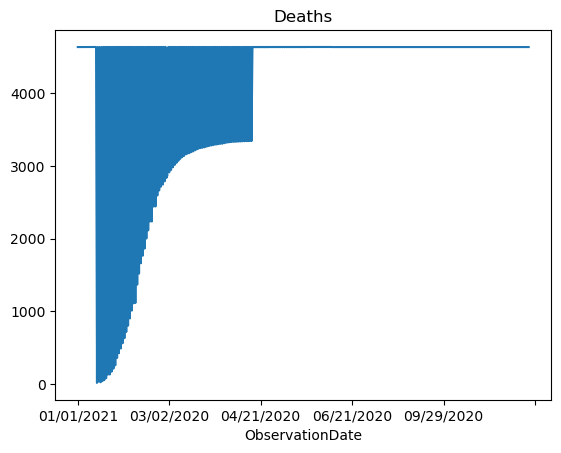

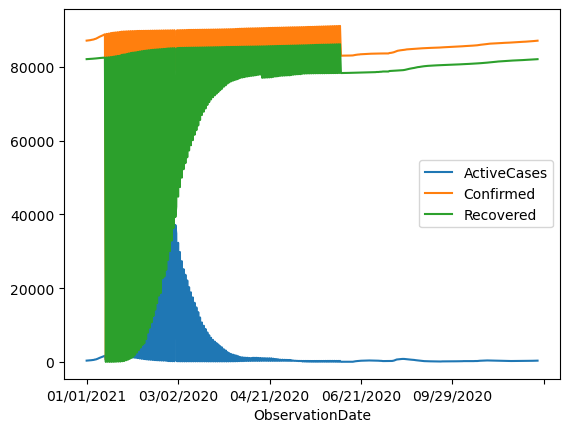

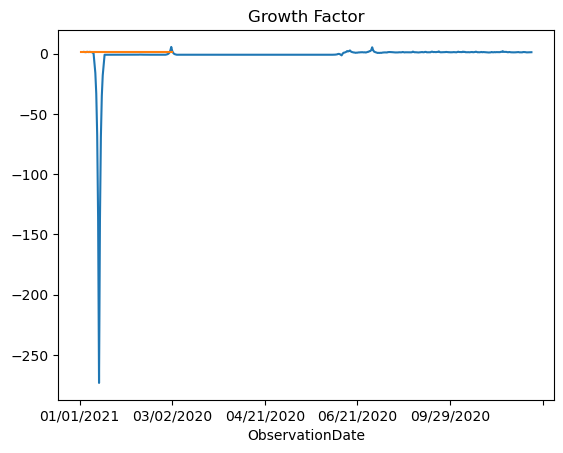

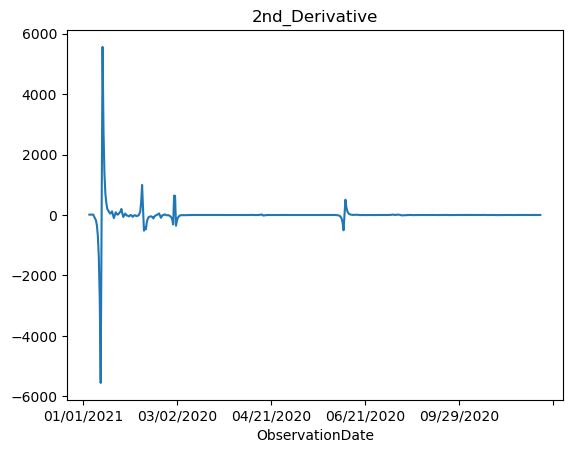

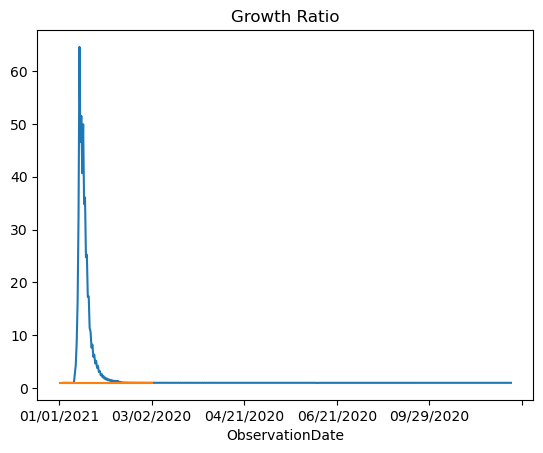

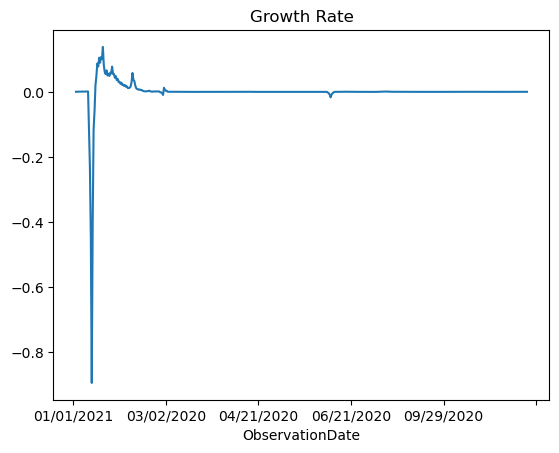

In [109]:
plot_country_active_confirmed_recovered('Mainland China')


In [110]:
prophet=bd_data.iloc[: , [4,5 ]].copy()
prophet.head()
prophet.columns = ['ds','y']
prophet.head()

ds  y
90    1/22/20  0
367   1/23/20  0
644   1/24/20  0
921   1/25/20  0
1198  1/26/20  0

In [111]:
m=Prophet()
m.fit(prophet)
future=m.make_future_dataframe(periods=15)
forecast=m.predict(future)
forecast

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1124: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:271: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

11:07:15 - cmdstanpy - INFO - Chain [1] start processing
11:07:15 - cmdstanpy - INFO - Chain [1] done processing


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2020-01-22 -2.021674   -4.576091    1.908478    -2.021674    -2.021674   
1  2020-01-23 -1.906197   -4.180943    2.271416    -1.906197    -1.906197   
2  2020-01-24 -1.790720   -5.913851    0.981945    -1.790720    -1.790720   
3  2020-01-25 -1.675244   -5.566431    1.043280    -1.675244    -1.675244   
4  2020-01-26 -1.559767   -5.437742    1.452670    -1.559767    -1.559767   
..        ...       ...         ...         ...          ...          ...   
68 2020-03-30  5.846385    2.600822    9.178270     5.845899     5.846852   
69 2020-03-31  5.962334    2.854728    9.397389     5.961779     5.962867   
70 2020-04-01  6.078282    3.295628    9.933417     6.077668     6.078886   
71 2020-04-02  6.194230    3.665778   10.400602     6.193539     6.194898   
72 2020-04-03  6.310179    2.271809    9.008532     6.309419     6.310936   

    additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0         0.680296              0.680296              0.680296  0.680296   
1         0.898235              0.898235              0.898235  0.898235   
2        -0.660036             -0.660036             -0.660036 -0.660036   
3        -0.775360             -0.775360             -0.775360 -0.775360   
4        -0.265696             -0.265696             -0.265696 -0.265696   
..             ...                   ...                   ...       ...   
68       -0.006043             -0.006043             -0.006043 -0.006043   
69        0.128604              0.128604              0.128604  0.128604   
70        0.680296              0.680296              0.680296  0.680296   
71        0.898235              0.898235              0.898235  0.898235   
72       -0.660036             -0.660036             -0.660036 -0.660036   

    weekly_lower  weekly_upper  multiplicative_terms  \
0       0.680296      0.680296                   0.0   
1       0.898235      0.898235                   0.0   
2      -0.660036     -0.660036                   0.0   
3      -0.775360     -0.775360                   0.0   
4      -0.265696     -0.265696                   0.0   
..           ...           ...                   ...   
68     -0.006043     -0.006043                   0.0   
69      0.128604      0.128604                   0.0   
70      0.680296      0.680296                   0.0   
71      0.898235      0.898235                   0.0   
72     -0.660036     -0.660036                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                          0.0                         0.0 -1.341378  
1                          0.0                         0.0 -1.007963  
2                          0.0                         0.0 -2.450757  
3                          0.0                         0.0 -2.450604  
4                          0.0                         0.0 -1.825463  
..                         ...                         ...       ...  
68                         0.0                         0.0  5.840342  
69                         0.0                         0.0  6.090938  
70                         0.0                         0.0  6.758578  
71                         0.0                         0.0  7.092465  
72                         0.0                         0.0  5.650142  

[73 rows x 16 columns]

In [112]:
cnfrm = forecast.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm']
cnfrm.head()

Date   Confirm
58 2020-03-20  4.686902
59 2020-03-21  4.802850
60 2020-03-22  4.918798
61 2020-03-23  5.034747
62 2020-03-24  5.150695

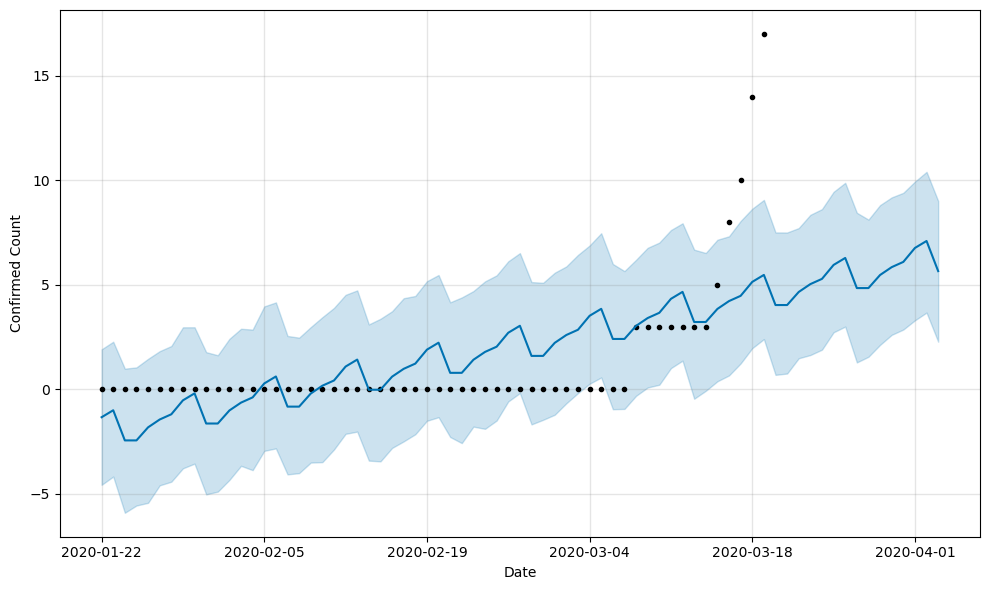

In [113]:
figure = plot_plotly(m, forecast)
py.iplot(figure)

figure = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')

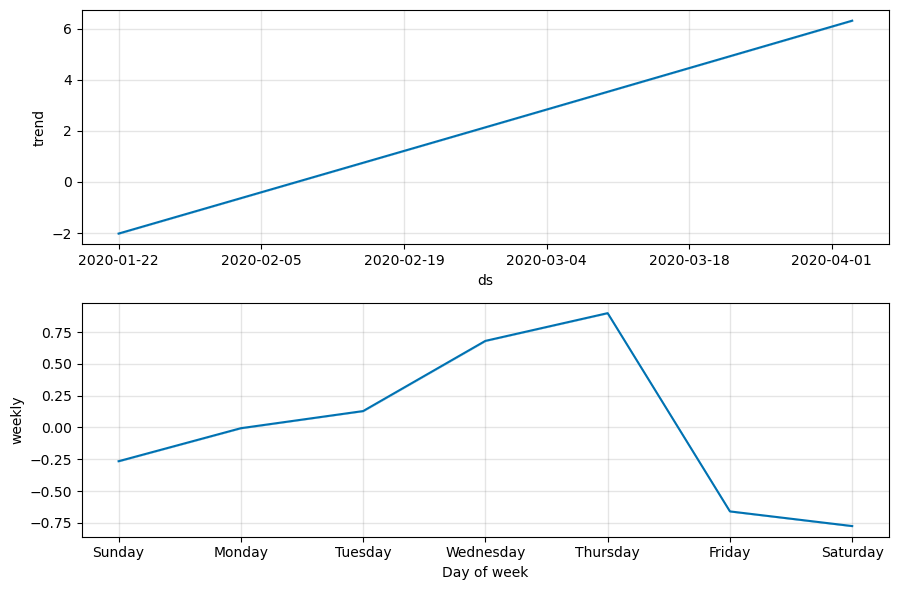

In [114]:
figure=m.plot_components(forecast)


In [115]:
prophet_rec=bd_data.iloc[: , [4,7 ]].copy()
prophet_rec.head()
prophet_rec.columns = ['ds','y']
prophet_rec.head()

ds  y
90    1/22/20  0
367   1/23/20  0
644   1/24/20  0
921   1/25/20  0
1198  1/26/20  0

In [116]:
m1=Prophet()
m1.fit(prophet_rec)
future_rec=m1.make_future_dataframe(periods=15)
forecast_rec=m1.predict(future_rec)
forecast_rec

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1124: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:271: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

11:07:18 - cmdstanpy - INFO - Chain [1] start processing
11:07:19 - cmdstanpy - INFO - Chain [1] done processing


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2020-01-22 -0.327768   -0.938265    0.687937    -0.327768    -0.327768   
1  2020-01-23 -0.309777   -0.962400    0.613774    -0.309777    -0.309777   
2  2020-01-24 -0.291786   -1.174287    0.359883    -0.291786    -0.291786   
3  2020-01-25 -0.273795   -1.190127    0.371828    -0.273795    -0.273795   
4  2020-01-26 -0.255804   -1.191516    0.323559    -0.255804    -0.255804   
..        ...       ...         ...         ...          ...          ...   
68 2020-03-30  0.895642    0.149655    1.742584     0.895641     0.895643   
69 2020-03-31  0.913634    0.254056    1.823771     0.913633     0.913635   
70 2020-04-01  0.931626    0.304570    1.865694     0.931625     0.931627   
71 2020-04-02  0.949618    0.292518    1.853225     0.949617     0.949619   
72 2020-04-03  0.967610    0.047563    1.632807     0.967608     0.967611   

    additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0         0.157774              0.157774              0.157774  0.157774   
1         0.139799              0.139799              0.139799  0.139799   
2        -0.148577             -0.148577             -0.148577 -0.148577   
3        -0.166548             -0.166548             -0.166548 -0.166548   
4        -0.184519             -0.184519             -0.184519 -0.184519   
..             ...                   ...                   ...       ...   
68        0.047518              0.047518              0.047518  0.047518   
69        0.154552              0.154552              0.154552  0.154552   
70        0.157774              0.157774              0.157774  0.157774   
71        0.139799              0.139799              0.139799  0.139799   
72       -0.148577             -0.148577             -0.148577 -0.148577   

    weekly_lower  weekly_upper  multiplicative_terms  \
0       0.157774      0.157774                   0.0   
1       0.139799      0.139799                   0.0   
2      -0.148577     -0.148577                   0.0   
3      -0.166548     -0.166548                   0.0   
4      -0.184519     -0.184519                   0.0   
..           ...           ...                   ...   
68      0.047518      0.047518                   0.0   
69      0.154552      0.154552                   0.0   
70      0.157774      0.157774                   0.0   
71      0.139799      0.139799                   0.0   
72     -0.148577     -0.148577                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                          0.0                         0.0 -0.169994  
1                          0.0                         0.0 -0.169978  
2                          0.0                         0.0 -0.440363  
3                          0.0                         0.0 -0.440343  
4                          0.0                         0.0 -0.440323  
..                         ...                         ...       ...  
68                         0.0                         0.0  0.943161  
69                         0.0                         0.0  1.068186  
70                         0.0                         0.0  1.089400  
71                         0.0                         0.0  1.089417  
72                         0.0                         0.0  0.819033  

[73 rows x 16 columns]

In [117]:
rec = forecast_rec.loc[:,['ds','trend']]
rec = rec[rec['trend']>0]
rec=rec.tail(15)
rec.columns = ['Date','Recovery']
rec.head()

Date  Recovery
58 2020-03-20  0.715724
59 2020-03-21  0.733715
60 2020-03-22  0.751707
61 2020-03-23  0.769699
62 2020-03-24  0.787691

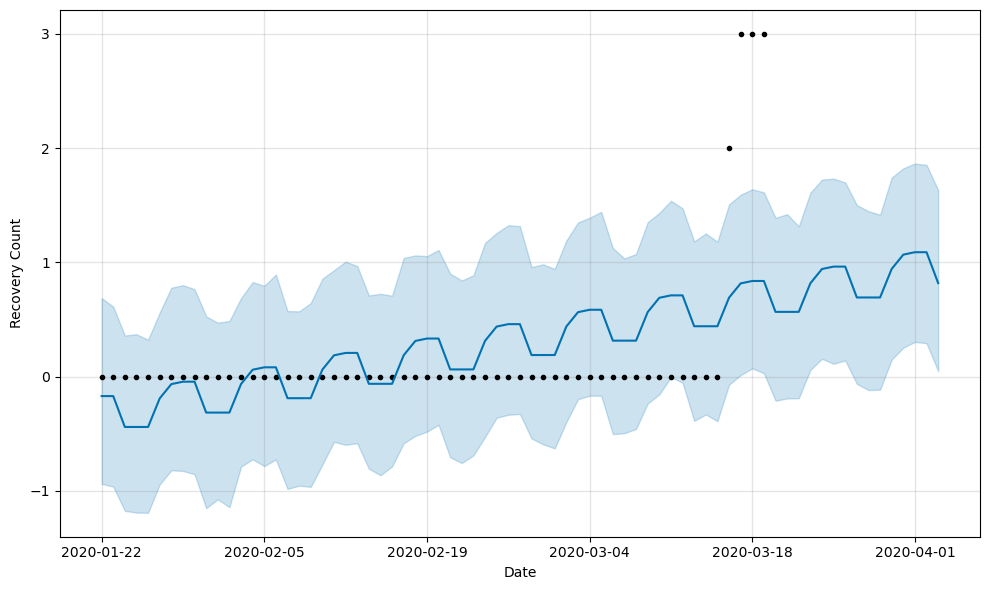

In [118]:
figure_rec = plot_plotly(m1, forecast_rec)
py.iplot(figure_rec)

figure_rec = m1.plot(forecast_rec,xlabel='Date',ylabel='Recovery Count')

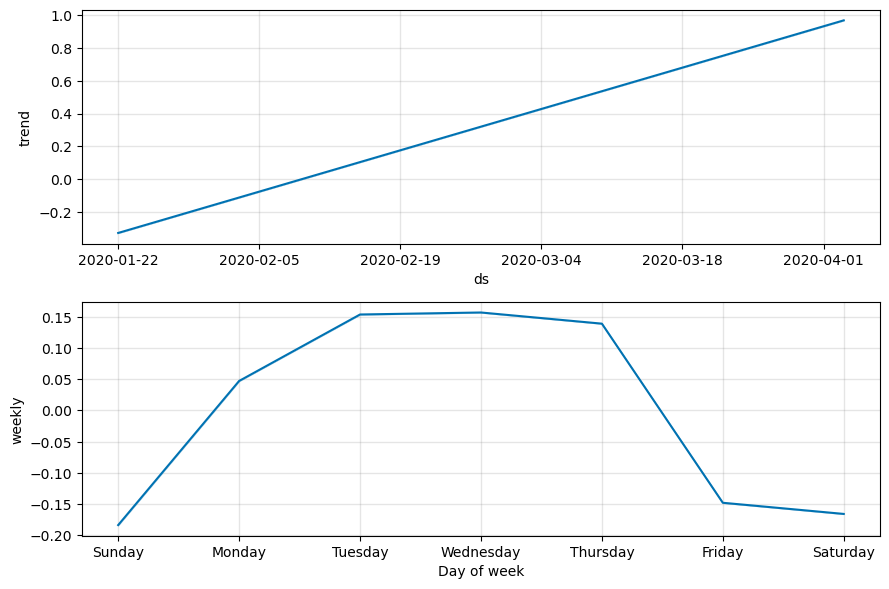

In [119]:
figure_rec=m1.plot_components(forecast_rec)


In [120]:
prophet_dth=bd_data.iloc[: , [4,6 ]].copy()
prophet_dth.head()
prophet_dth.columns = ['ds','y']
prophet_dth.head()

ds  y
90    1/22/20  0
367   1/23/20  0
644   1/24/20  0
921   1/25/20  0
1198  1/26/20  0

In [121]:
m2=Prophet()
m2.fit(prophet_dth)
future_dth=m2.make_future_dataframe(periods=15)
forecast_dth=m2.predict(future_dth)
forecast_dth

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1124: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/Users/reeaarana/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:271: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

11:07:20 - cmdstanpy - INFO - Chain [1] start processing
11:07:21 - cmdstanpy - INFO - Chain [1] done processing


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2020-01-22 -0.066703   -0.199637    0.225902    -0.066703    -0.066703   
1  2020-01-23 -0.063249   -0.195845    0.207296    -0.063249    -0.063249   
2  2020-01-24 -0.059794   -0.317750    0.126697    -0.059794    -0.059794   
3  2020-01-25 -0.056339   -0.291074    0.116651    -0.056339    -0.056339   
4  2020-01-26 -0.052885   -0.292919    0.135839    -0.052885    -0.052885   
..        ...       ...         ...         ...          ...          ...   
68 2020-03-30  0.168221   -0.094458    0.337025     0.168221     0.168222   
69 2020-03-31  0.171676   -0.085577    0.352918     0.171676     0.171677   
70 2020-04-01  0.175131    0.048991    0.481313     0.175131     0.175131   
71 2020-04-02  0.178586    0.035623    0.453749     0.178586     0.178586   
72 2020-04-03  0.182041   -0.044188    0.363160     0.182041     0.182041   

    additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0         0.081110              0.081110              0.081110  0.081110   
1         0.077653              0.077653              0.077653  0.077653   
2        -0.024839             -0.024839             -0.024839 -0.024839   
3        -0.028296             -0.028296             -0.028296 -0.028296   
4        -0.031752             -0.031752             -0.031752 -0.031752   
..             ...                   ...                   ...       ...   
68       -0.035209             -0.035209             -0.035209 -0.035209   
69       -0.038667             -0.038667             -0.038667 -0.038667   
70        0.081110              0.081110              0.081110  0.081110   
71        0.077653              0.077653              0.077653  0.077653   
72       -0.024839             -0.024839             -0.024839 -0.024839   

    weekly_lower  weekly_upper  multiplicative_terms  \
0       0.081110      0.081110                   0.0   
1       0.077653      0.077653                   0.0   
2      -0.024839     -0.024839                   0.0   
3      -0.028296     -0.028296                   0.0   
4      -0.031752     -0.031752                   0.0   
..           ...           ...                   ...   
68     -0.035209     -0.035209                   0.0   
69     -0.038667     -0.038667                   0.0   
70      0.081110      0.081110                   0.0   
71      0.077653      0.077653                   0.0   
72     -0.024839     -0.024839                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                          0.0                         0.0  0.014406  
1                          0.0                         0.0  0.014405  
2                          0.0                         0.0 -0.084633  
3                          0.0                         0.0 -0.084635  
4                          0.0                         0.0 -0.084637  
..                         ...                         ...       ...  
68                         0.0                         0.0  0.133012  
69                         0.0                         0.0  0.133010  
70                         0.0                         0.0  0.256241  
71                         0.0                         0.0  0.256239  
72                         0.0                         0.0  0.157202  

[73 rows x 16 columns]

In [122]:
dth = forecast_dth.loc[:,['ds','trend']]
dth = dth[dth['trend']>0]
dth=dth.tail(15)
dth.columns = ['Date','Death']
dth.head()

Date     Death
58 2020-03-20  0.133673
59 2020-03-21  0.137127
60 2020-03-22  0.140582
61 2020-03-23  0.144037
62 2020-03-24  0.147492

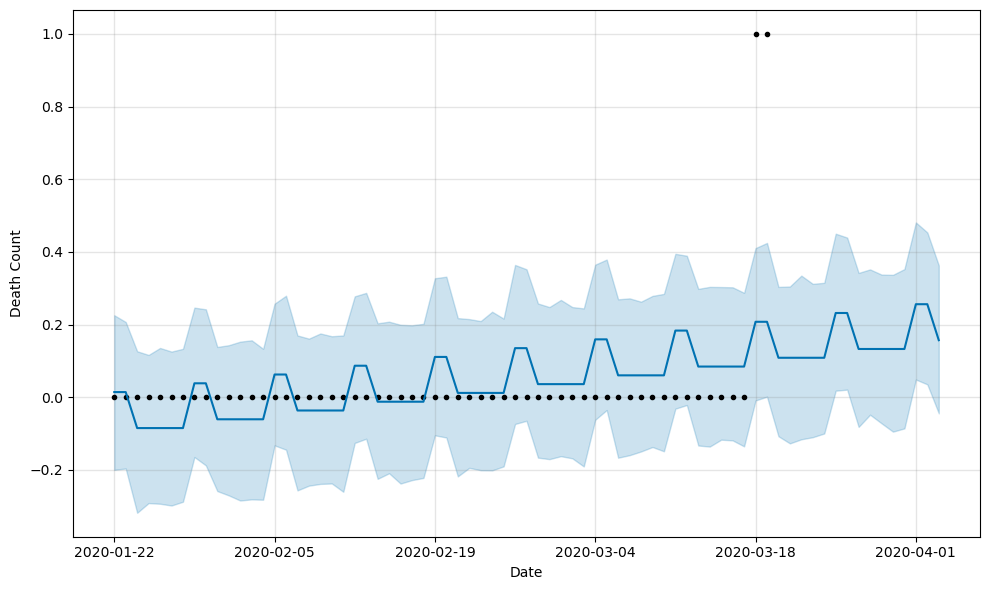

In [123]:
figure_dth = plot_plotly(m2, forecast_dth)
py.iplot(figure_dth)

figure_dth = m2.plot(forecast_dth,xlabel='Date',ylabel='Death Count')

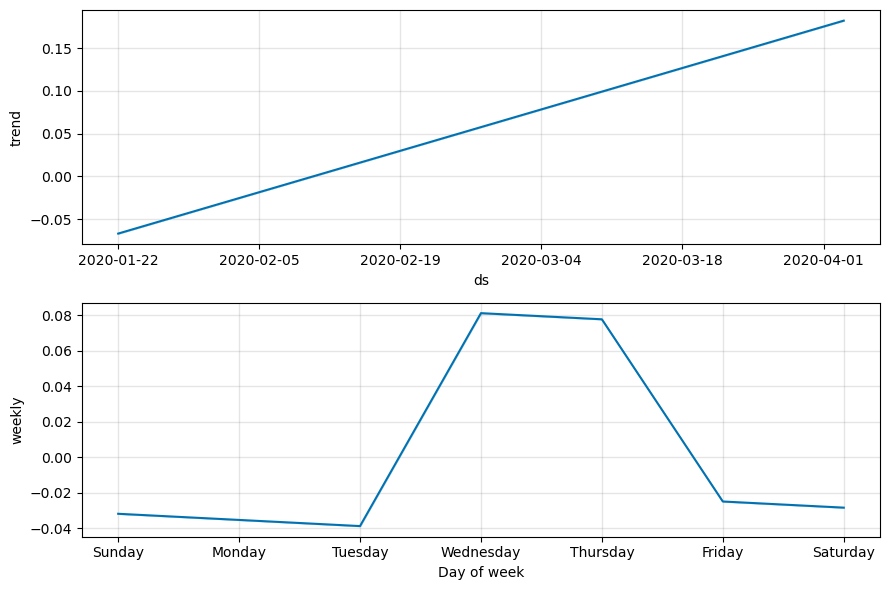

In [124]:
figure_dth=m2.plot_components(forecast_dth)


In [125]:
prediction = cnfrm
prediction['Recover'] = rec.Recovery
prediction['Death'] = dth.Death
prediction.head()

Date   Confirm   Recover     Death
58 2020-03-20  4.686902  0.715724  0.133673
59 2020-03-21  4.802850  0.733715  0.137127
60 2020-03-22  4.918798  0.751707  0.140582
61 2020-03-23  5.034747  0.769699  0.144037
62 2020-03-24  5.150695  0.787691  0.147492

In [126]:
pr_pps = float(prediction.Recover.sum()/prediction.Confirm.sum())
pd_pps = float(prediction.Death.sum()/prediction.Confirm.sum())

In [127]:
print("The percentage of Predicted recovery after confirmation is "+ str(pr_pps*100) )
print("The percentage of Predicted Death after confirmation is "+ str(pd_pps*100) )

The percentage of Predicted recovery after confirmation is 15.307091808625445
The percentage of Predicted Death after confirmation is 2.8708851629429106
